# More examples with Pyphot

<div class="alert alert-block alert-info">

ℹ️ This notebook is based on **Pyphot version 2.0.0.**

</div>

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Handle import for pyphot and path
import sys

try:
    import pyphot
except ImportError:
    sys.path.append("../")
    import pyphot

## Basic usage

This example reads a spectrum from a fits file and calculate some photometry using units to the calculations.
We retrieve the data directly from the [CDBS archive](https://archive.stsci.edu/hlsps/reference-atlases/cdbs).

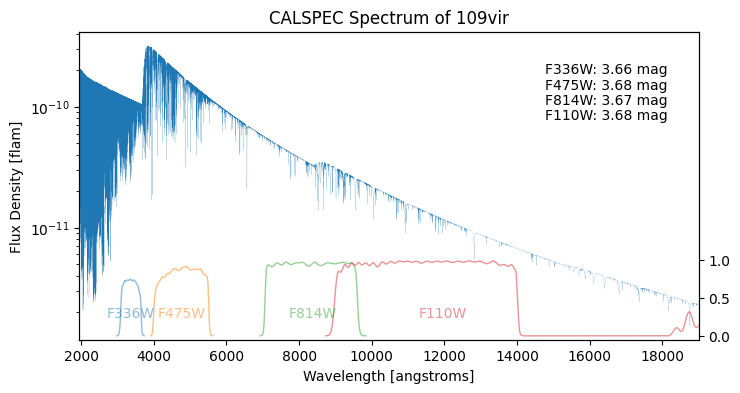

In [3]:
# Example data from CalSpec CDBS archive
# 109 Vir is A0 V star
url = "https://archive.stsci.edu/hlsps/reference-atlases/cdbs/current_calspec/109vir_mod_005.fits"

from astropy.io import fits
from pyphot import config
import numpy as np
from pyphot import get_library

units = config.units

# get the spectrum
with fits.open(url) as hdul:
    data = hdul[1].data
    wavelength = data['WAVELENGTH']  
    wavelength_units = hdul[1].header['TUNIT1'].lower()
    flux = data['FLUX']  
    flux_units = hdul[1].header['TUNIT2'].lower()
    target_name = hdul[0].header['TARGETID'].strip()

# compute some photometry
lib = pyphot.get_library()
flist = lib['HST_WFC3_F336W', 'HST_WFC3_F475W', 'HST_WFC3_F814W', 'HST_WFC3_F110W']
sed = {}
minλ, maxλ = np.inf, 0
for f in flist:
    minλ = min(minλ, np.nanmin(f.wavelength.value))
    maxλ = max(maxλ, np.nanmax(f.wavelength.value))
    sed[f.name] = -2.5 * np.log10(f.get_flux(wavelength, flux) / f.Vega_zero_flux)

# make a plot
plt.figure(figsize=(8, 4))
λ, fλ = wavelength * units.U(wavelength_units), flux * units.U(flux_units)
ind = np.where((λ.value >= minλ) & (λ.value <= maxλ))
plt.semilogy(λ[ind], fλ[ind], lw=0.1)
plt.xlabel(f"Wavelength [{λ.unit}]")
plt.ylabel(f"Flux Density [{fλ.unit}]")
plt.title(f"CALSPEC Spectrum of {target_name}")
plt.xlim(minλ, maxλ)


for e, (name, m) in enumerate(sed.items()):
    name = name.split('_')[-1]
    plt.text(0.95, 0.9 - e * 0.05, f"{name}: {m:.2f} mag", transform=plt.gca().transAxes, va='top', ha='right')

ax = plt.twinx()
for f in flist:
    ind = f.transmit > 1e-3
    lines = ax.plot(f.wavelength[ind], f.transmit[ind], label=f.name, lw=1, alpha=0.5)
    ax.text(f.wavelength[ind].mean().value, 0.2, f.name.split('_')[-1], va='bottom', ha='center', alpha=0.5, color=lines[0].get_color())
    ax.set_ylim(-0.05, 4)
    ax.set_yticks([0, 0.5, 1.0])

## Number of photons through a given passband

The following examples gives the number of photons that a passband would collect for the Sun at 10 pc.

In [4]:
from pyphot import Sun
from pyphot import config
from pyphot import get_library

units = config.units

lib = get_library()
vband = lib['GROUND_JOHNSON_V']
with Sun(distance=10 * units.U('pc')) as v:
    print(vband.get_Nphotons(v.wavelength, v.flux))

11.978459664247094 ph / (Angstrom s cm2)


The result is given in photon (ph) density.

## Defining your own passband

It is not uncommon to want to define your own passbands for specific applications or to use a passband that is not included in the libraries or even not yet public. Pyphot makes it easy to define your own passbands.

Let’s suppose you’re interested in defining bandpasses (here tophat functions) in Pyphot to determine the flux/magnitude in regions. This may be useful to determine the S/N ratio or integrated flux over a given wavelength range.

In [5]:
from pyphot import config, Filter
import numpy as np
units = config.units

wave = np.array([4499, 4500, 4700, 4701]) * units.U('AA')   # AA or Angstrom, angstrom
transmit = np.array([0., 1., 1., 0.])
tophat = Filter(wave, transmit, name='tophat', dtype='photon')
# flux_tophat = tophat.get_flux(wavelength, flux)
tophat.info()

Filter object information:
    name:                 tophat
    detector type:        photon
    wavelength units:     Angstrom
    central wavelength:   4600.000000 Angstrom
    pivot wavelength:     4598.912915 Angstrom
    effective wavelength: 4598.652110 Angstrom
    photon wavelength:    4599.388021 Angstrom
    minimum wavelength:   4500.000000 Angstrom
    maximum wavelength:   4700.000000 Angstrom
    norm:                 201.000000
    effective width:      201.000000 Angstrom
    fullwidth half-max:   201.000000 Angstrom
    definition contains 4 points
    Zeropoints
        Vega: 20.546119 mag,
              6.0471716338210665e-09 erg / (Angstrom s cm2),
              4266.207392559406 Jy
              1400.5107759682307 ph / (Angstrom s cm2)
          AB: 20.721224 mag,
              5.1464804957629885e-09 erg / (Angstrom s cm2),
              3630.780547701009 Jy
          ST: 21.100000 mag,
              3.6307805477010028e-09 erg / (Angstrom s cm2),
              2561

```{tip}
The transmission is unitless. Its scaling factor will not affect the flux/magnitude calculations as these are implicitly normalizing the passband (see the equations) but will affect the number of photons.
```


## Flux density units

Photometry calculations are sensitive to the units of the input spectra for the wavelength and spectral density. Internally Pyphot can deal with a lot of different units, as long as these are wavelength based (i.e. not frequencies).

Photometry expects the spectral density in `flam`, i.e., :math:`erg/s/cm^2/\unicode{x212B}`, any other similar units will be converted internally, e.g. $W/m^2/mn$. But when you deal with frequencies (e.g., `fnu`), you need to convert these to `flam` first.

if you use the Astropy units, you can use it to convert flux densities from frequencies to flam

```python3

        from astropy import units as u

        flux = u.Quantity(spec['flux']).to(u.Unit('flam')), 
                equivalencies=u.spectral_density(u.Quantity(spec['wave']))
                )
```

Other unit systems can be used but may be more tedious to convert.

```{tip}
When using Astropy units with pyphot (default), Astropy _automagically_ inherits the custom unit `flam` defined in pyphot.

Make sure to use `u.Unit('flam')` and not `u.flam` which is not defined in Astropy.
```

In [6]:
from astropy import units as u
# astropy Unit(...) gives a unit object, 1 * Unit(...) is a quantity. 
# Unit(...).to(...) gives a scaling factor (float)
# 1 * Unit(...).to(...) gives another quantity which has units.
(1 * u.Unit('flam')).to('W * m ** (-2) * nm **(-1)')

<Quantity 0.01 W / (nm m2)>

## Dust attenuated SED modeling

A complete tutorial can be found [online](https://github.com/mfouesneau/GaiaSprint2018/blob/master/dust_attenuated_seds.ipynb). It requires a bit more than just `Pyphot`, but it demonstrates how to integrate `Pyphot` into larger projects. 

In [7]:
import pyphot

# get the internal default library of passbands filters
lib = pyphot.get_library()
print("Library contains: ", len(lib), " filters")
# find all filter names that relates to IRAC
# and print some info
f = lib.find("irac")
passbands = lib.load_filters(f)  # or lib[f]
passbands[0].info(show_zeropoints=True)

Library contains:  271  filters
Filter object information:
    name:                 SPITZER_IRAC_36
    detector type:        photon
    wavelength units:     AA
    central wavelength:   35634.293911 Angstrom
    pivot wavelength:     35569.270678 Angstrom
    effective wavelength: 35134.320010 Angstrom
    photon wavelength:    35263.773954 Angstrom
    minimum wavelength:   31310.000000 Angstrom
    maximum wavelength:   39740.000000 Angstrom
    norm:                 3181.966405
    effective width:      6848.829972 Angstrom
    fullwidth half-max:   7430.000000 Angstrom
    definition contains 505 points
    Zeropoints
        Vega: 27.948397 mag,
              6.616697169302651e-12 erg / (Angstrom s cm2),
              279.2354008243633 Jy
              5.5117355961901255 ph / (Angstrom s cm2)
          AB: 25.163323 mag,
              8.603413213872212e-11 erg / (Angstrom s cm2),
              3630.7805477009956 Jy
          ST: 21.100000 mag,
              3.6307805477010028e-

## Unit backends in pyphot

Pyphot supports multiple unit backends through its `pyphot.unit_adapter` module. By default, it uses Astropy units, but you can also use Pint.

All adapters must implement the `UnitsAdapter` interface, which defines the following methods:

- `UnitsAdapter.U()`: queries the unit registry.
- `UnitsAdapter.Q()`: make sure the returned object is a quantity, i.e. a value with unit (e.g. astropy differs between `U("kg")` and `Q("kg") = 1. * U("kg")`)

For source typing reasons, adapters also override a few methods:

- `UnitsAdapter.has_unit`: checks if the object has a unit.
- `UnitsAdapter.val_in_unit`: returns the value of the quantity in the specified unit or forces a default unit if not specified.

When using `config.units` it refers to the global adapter instance, which can be changed at runtime by setting `pyphot.config.set_units_backend` to another adapter instance.

```{admonition} API details

For more details, see the [`unit_adapter` module documentation](https://mfouesneau.github.io/pyphot/pyphot.unit_adapters.html).
```


In [8]:
from pyphot import Vega 

vega = Vega()
wavelength_angstrom = vega.wavelength
wavelength_nm = vega.wavelength.to('nm')
flux_flam = vega.flux
flux_other = flux_flam.to('W / (m**2 * nm)')
wavelength_angstrom, wavelength_nm, flux_flam, flux_other

(<Quantity [9.00452026e+02, 9.01354004e+02, 9.02257996e+02, ...,
            2.99353200e+06, 2.99653275e+06, 2.99953700e+06] Angstrom>,
 <Quantity [9.00452026e+01, 9.01354004e+01, 9.02257996e+01, ...,
            2.99353200e+05, 2.99653275e+05, 2.99953700e+05] nm>,
 <Quantity [1.23800003e-17, 1.67599994e-17, 1.78000003e-17, ...,
            1.40099994e-19, 1.38700004e-19, 1.26499994e-19] flam>,
 <Quantity [1.23800003e-19, 1.67599994e-19, 1.78000003e-19, ...,
            1.40099994e-21, 1.38700004e-21, 1.26499994e-21] W / (nm m2)>)